# Libraries

In [1]:
from platform import python_version

import numpy as np
import pandas as pd
import seaborn as sns

print(f'python_version: {python_version()}')
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'seaborn: {sns.__version__}')

python_version: 3.12.5
pandas: 2.2.3
numpy: 2.1.2
seaborn: 0.13.2


# Data

In [2]:
app_data = pd.read_csv('application_record.csv')
cre_data = pd.read_csv('credit_record.csv')
app_data.shape, cre_data.shape

((438557, 18), (1048575, 3))

In [3]:
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
cre_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


__checking missing values__

In [5]:
app_data.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [6]:
cre_data.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

__checking datatypes__

In [7]:
app_data.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

In [8]:
cre_data.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

__checking percentage of duplicates in both datasets__

In [9]:
print(
    f"Duplicates in applications df: {app_data.iloc[:, 1:].duplicated().sum()}, ({np.round(100 * app_data.iloc[:, 1:].duplicated().sum() / len(app_data), 1)}%)"
)
print()
print(
    f"Duplicates in credit_record df: {cre_data.duplicated().sum()}, ({np.round(100 * cre_data.duplicated().sum() / len(app_data), 1)}%)"
)

Duplicates in applications df: 348472, (79.5%)

Duplicates in credit_record df: 0, (0.0%)


__Checking Cardinality of features__

In [10]:
app_data.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [11]:
cre_data.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [12]:
cre_data['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

After checking the results returned from ```nunique``` method, I found out that 

__application_record__ has:
- 1 constant feature
- 3 continuous features
- 6 binary categorical features
- 3 non-binary categorical features

__credit_record__ has:
- 1 continuous feature
- 1 nonbinary categorical feature which is our target variable

# Data Cleaning


__droping duplicates__

In [13]:
print("shape before dropping duplicates:", app_data.shape)
app_data = app_data.drop_duplicates(subset=app_data.columns[1:], keep="first")
print("shape after dropping duplicates:", app_data.shape)

shape before dropping duplicates: (438557, 18)
shape after dropping duplicates: (90085, 18)


__drop constant feature__

Since there is only 1 unique value in ```FLAG_MOBIL``` I consider it is not useful for training. I decided to drop this feature

In [14]:
app_data.drop('FLAG_MOBIL', axis=1, inplace=True)

**create target variable**

Since the credit records are incomplete and id ranges in both dataframes don't match, it is better to create our own target label. By identifying _low risk_ and _high risk_ users we can mitigate this. If a user is late on payments by 30 days or more, we can mark the user is _high risk_. Otherwise, the user is _low risk_.

In [15]:
cre_data['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [16]:
cre_data["target"] = cre_data["STATUS"]

# replace
cre_data["target"] = cre_data["target"].replace(["C", "X"], 0)
cre_data["target"] = cre_data["target"].astype(int)
cre_data.loc[cre_data["target"] > 1, "target"] = 1
cre_data.head()

,ID,MONTHS_BALANCE,STATUS,target
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [17]:
target_df = pd.DataFrame(cre_data.groupby(['ID'])['target'].agg('max')).reset_index()
print(target_df.shape)
print(cre_data.shape)
target_df.head()

(45985, 2)
(1048575, 4)


,ID,target
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [18]:
# merge dataframes to create final df
final_df = pd.merge(app_data, target_df, on='ID', how='inner')
final_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,1
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,NaN,1.0,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,0


__Account Length__
The number of months the account has been open for correlates with the riskiness of the customer. Longer the account has been opened, there are more opportunity to miss payments.

In [19]:
# calculate how many months an account has been open for
start_df = pd.DataFrame(cre_data.groupby(['ID'])['MONTHS_BALANCE'].agg('min')).reset_index()

start_df = start_df.rename(columns={'MONTHS_BALANCE': 'ACCOUNT_LENGTH'})

# make entries positive
start_df['ACCOUNT_LENGTH'] = - start_df['ACCOUNT_LENGTH']

start_df.head(10)

,ID,ACCOUNT_LENGTH
0,5001711,3
1,5001712,18
2,5001713,21
3,5001714,14
4,5001715,59
5,5001717,21
6,5001718,38
7,5001719,42
8,5001720,35
9,5001723,30


In [20]:
# merge into final dataframe
final_df = pd.merge(final_df, start_df, on='ID', how='inner')
final_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,ACCOUNT_LENGTH
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,1,15
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,0,29
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,0,4
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,NaN,1.0,0,20
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,0,5


**creating new continuous features and dropping unnecessary columns**

According to NASA there are 365.24225 days in a year

https://pumas.nasa.gov/examples/how-many-days-are-year

In [21]:
# create age feature
final_df["AGE_YEARS"] = -final_df["DAYS_BIRTH"] / 365.24225

# create unemployed indicator, negative values mean days being unemployted
final_df["EMPLOYED"] = 1
final_df.loc[-final_df["DAYS_EMPLOYED"] < 0, "EMPLOYED"] = 0

# decimal values less than 1 should be considered as 0
final_df["YEARS_EMPLOYED"] = -final_df["DAYS_EMPLOYED"] / 365.24225
final_df.loc[final_df["YEARS_EMPLOYED"] < 0, "YEARS_EMPLOYED"] = 0

# drop unnecssary columns
final_df = final_df.drop(columns=["DAYS_BIRTH", "DAYS_EMPLOYED"])

In [22]:
final_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,ACCOUNT_LENGTH,AGE_YEARS,EMPLOYED,YEARS_EMPLOYED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,1,15,32.868596,1,12.435582
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,29,58.793855,1,3.104789
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,4,52.321439,1,8.353360
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,NaN,1.0,0,20,61.504385,0,0.000000
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,5,46.193999,1,2.105452


**encoding binary features**

In [23]:
final_df["CODE_GENDER"] = final_df["CODE_GENDER"].map({'F': 0, 'M': 1}).astype(int)
final_df["FLAG_OWN_CAR"] = final_df["FLAG_OWN_CAR"].map({'Y': 1, 'N': 0}).astype(int)
final_df["FLAG_OWN_REALTY"] = final_df["FLAG_OWN_REALTY"].map({'Y': 1, 'N': 0}).astype(int)

**renaming columns**

In [24]:
final_df = final_df.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'OwnCar',
                                    'FLAG_OWN_REALTY': 'OwnProperty', 'CNT_CHILDREN': 'ChildrenCount',
                                    'AMT_INCOME_TOTAL': 'TotalIncome', 'NAME_INCOME_TYPE': 'IncomeType',
                                    'NAME_EDUCATION_TYPE': 'EducationType', 'NAME_FAMILY_STATUS': 'FamilyStatus',
                                    'NAME_HOUSING_TYPE': 'HousingType', 'FLAG_WORK_PHONE': 'WorkPhone',
                                    'FLAG_PHONE': 'Phone', 'FLAG_EMAIL': 'Email', 'OCCUPATION_TYPE': 'OccupationType',
                                    'CNT_FAM_MEMBERS': 'FamilyMembers', 'target': 'Target',
                                    'ACCOUNT_LENGTH': 'AccountLength',
                                    'AGE_YEARS': 'Age', 'UNEMPLOYED': 'Unemployed', 'YEARS_EMPLOYED': 'YearsEmployed'})

final_df.head()

,ID,Gender,OwnCar,OwnProperty,ChildrenCount,TotalIncome,IncomeType,EducationType,FamilyStatus,HousingType,WorkPhone,Phone,Email,OccupationType,FamilyMembers,Target,AccountLength,Age,EMPLOYED,YearsEmployed
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,1,15,32.868596,1,12.435582
1,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,29,58.793855,1,3.104789
2,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,4,52.321439,1,8.353360
3,5008812,0,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,NaN,1.0,0,20,61.504385,0,0.000000
4,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,5,46.193999,1,2.105452


**data types**

In [25]:
final_df['FamilyMembers'] = final_df['FamilyMembers'].astype(int)

In [26]:
final_df.head()

,ID,Gender,OwnCar,OwnProperty,ChildrenCount,TotalIncome,IncomeType,EducationType,FamilyStatus,HousingType,WorkPhone,Phone,Email,OccupationType,FamilyMembers,Target,AccountLength,Age,EMPLOYED,YearsEmployed
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2,1,15,32.868596,1,12.435582
1,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,0,29,58.793855,1,3.104789
2,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,0,4,52.321439,1,8.353360
3,5008812,0,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,NaN,1,0,20,61.504385,0,0.000000
4,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2,0,5,46.193999,1,2.105452


In [27]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              9709 non-null   int64  
 1   Gender          9709 non-null   int64  
 2   OwnCar          9709 non-null   int64  
 3   OwnProperty     9709 non-null   int64  
 4   ChildrenCount   9709 non-null   int64  
 5   TotalIncome     9709 non-null   float64
 6   IncomeType      9709 non-null   object 
 7   EducationType   9709 non-null   object 
 8   FamilyStatus    9709 non-null   object 
 9   HousingType     9709 non-null   object 
 10  WorkPhone       9709 non-null   int64  
 11  Phone           9709 non-null   int64  
 12  Email           9709 non-null   int64  
 13  OccupationType  6715 non-null   object 
 14  FamilyMembers   9709 non-null   int64  
 15  Target          9709 non-null   int64  
 16  AccountLength   9709 non-null   int64  
 17  Age             9709 non-null   f

**checking unique values in categorical features**

In [28]:
print(f'IncomeTypes: {final_df['IncomeType'].unique()}\n')
print(f'EducationTypes: {final_df['EducationType'].unique()}\n')
print(f'FamilyStatus: {final_df['FamilyStatus'].unique()}\n')
print(f'HousingType: {final_df['HousingType'].unique()}\n')
print(f'OccupationType: {final_df['OccupationType'].unique()}\n')

IncomeTypes: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

EducationTypes: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

FamilyStatus: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

HousingType: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']

OccupationType: [nan 'Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']



**check if** ```OccupationType``` **should be dropped or not**

In [29]:
final_df['OccupationType'].value_counts()

OccupationType
Laborers                 1724
Sales staff               959
Core staff                877
Managers                  782
Drivers                   623
High skill tech staff     357
Accountants               300
Medicine staff            291
Cooking staff             193
Security staff            182
Cleaning staff            146
Private service staff      86
Low-skill Laborers         53
Secretaries                46
Waiters/barmen staff       40
HR staff                   22
IT staff                   18
Realty agents              16
Name: count, dtype: int64

**encoding categories**

Since these categories have an ordinal order. I will use ordinal order.

From higest to lowest in ordinality:

```IncomeType```
4. State servent
3. Working
2. Commercial associate
1. Pensioner
0. Student

```FamilyStatus```
4. Married (highest stability)
3. Civil marriage (committed but not formally married)
2. Widow (previously married)
1. Separated (previously in a committed relationship)
0. Single / not married (lowest stability)

```HousingType```
5. House / apartment (own or stable living)
4. Co-op apartment (indicating shared ownership or cooperative living)
3. Rented apartment (relatively stable but rented)
2. Municipal apartment (state or government-supported housing)
1. Office apartment (less stable, typically temporary)
0. With parents (least independent, usually indicating early life stage or dependence)

```EducationType```
4. Academic degree (highest)
3. Higher education
2. Incomplete higher
1. Secondary / secondary special
0. Lower secondary (lowest


In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

final_df['OccupationType_encoded'] = le.fit_transform(final_df['OccupationType'])

occupation_target_corr = final_df[['OccupationType_encoded', 'Target']].corr().iloc[0, 1]
occupation_target_corr

np.float64(-0.020191896773687414)

```OccupationType``` feature has 19 unique categories, with ```Other``` being the most common and categories like ```Realty agents``` having only 16 entries. 
Correlation between ```OccupationType``` and the ```Target``` variable is quite low at approximately −0.02. This indicates that it has a very weak linear relationship with ```Target```. There is no occupation data for some users as well. Therefore, I decided to drop this column. 

In [31]:
final_df = final_df.drop(columns=['OccupationType', 'OccupationType_encoded'])
final_df.head()

,ID,Gender,OwnCar,OwnProperty,ChildrenCount,TotalIncome,IncomeType,EducationType,FamilyStatus,HousingType,WorkPhone,Phone,Email,FamilyMembers,Target,AccountLength,Age,EMPLOYED,YearsEmployed
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,2,1,15,32.868596,1,12.435582
1,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,2,0,29,58.793855,1,3.104789
2,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,1,0,4,52.321439,1,8.353360
3,5008812,0,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,1,0,20,61.504385,0,0.000000
4,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,2,0,5,46.193999,1,2.105452


In [32]:
from sklearn.preprocessing import OrdinalEncoder

income_type_order = ['Student', 'Pensioner', 'Commercial associate', 'Working', 'State servant']
education_order = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education',
                   'Academic degree']
family_status_order = ['Single / not married', 'Separated', 'Widow', 'Civil marriage', 'Married']
housing_type_order = ['With parents', 'Office apartment', 'Municipal apartment', 'Rented apartment', 'Co-op apartment',
                      'House / apartment']

encoder = OrdinalEncoder(categories=[income_type_order, education_order, family_status_order, housing_type_order])

final_df[['IncomeType', 'EducationType', 'FamilyStatus', 'HousingType']] = encoder.fit_transform(
    final_df[['IncomeType' ,'EducationType', 'FamilyStatus', 'HousingType']])

# display mapping generated by OrdinalEncoder
for feature, categories in zip(['IncomeType', 'EducationType', 'FamilyStatus', 'HousingType'], encoder.categories_):
    print(f"Mapping for {feature}:")
    for i, category in enumerate(categories):
        print(f"  {category}: {i}")

Mapping for IncomeType:
  Student: 0
  Pensioner: 1
  Commercial associate: 2
  Working: 3
  State servant: 4
Mapping for EducationType:
  Lower secondary: 0
  Secondary / secondary special: 1
  Incomplete higher: 2
  Higher education: 3
  Academic degree: 4
Mapping for FamilyStatus:
  Single / not married: 0
  Separated: 1
  Widow: 2
  Civil marriage: 3
  Married: 4
Mapping for HousingType:
  With parents: 0
  Office apartment: 1
  Municipal apartment: 2
  Rented apartment: 3
  Co-op apartment: 4
  House / apartment: 5


In [33]:
final_df.head()

,ID,Gender,OwnCar,OwnProperty,ChildrenCount,TotalIncome,IncomeType,EducationType,FamilyStatus,HousingType,WorkPhone,Phone,Email,FamilyMembers,Target,AccountLength,Age,EMPLOYED,YearsEmployed
0,5008804,1,1,1,0,427500.0,3.0,3.0,3.0,3.0,1,0,0,2,1,15,32.868596,1,12.435582
1,5008806,1,1,1,0,112500.0,3.0,1.0,4.0,5.0,0,0,0,2,0,29,58.793855,1,3.104789
2,5008808,0,0,1,0,270000.0,2.0,1.0,0.0,5.0,0,1,1,1,0,4,52.321439,1,8.353360
3,5008812,0,0,1,0,283500.0,1.0,3.0,1.0,5.0,0,0,0,1,0,20,61.504385,0,0.000000
4,5008815,1,1,1,0,270000.0,3.0,3.0,4.0,5.0,1,1,1,2,0,5,46.193999,1,2.105452


In [34]:
final_df.dtypes

ID                 int64
Gender             int64
OwnCar             int64
OwnProperty        int64
ChildrenCount      int64
TotalIncome      float64
IncomeType       float64
EducationType    float64
FamilyStatus     float64
HousingType      float64
WorkPhone          int64
Phone              int64
Email              int64
FamilyMembers      int64
Target             int64
AccountLength      int64
Age              float64
EMPLOYED           int64
YearsEmployed    float64
dtype: object

In [35]:
final_df.to_csv('final_df.csv', index=False)

<Axes: xlabel='Target', ylabel='count'>

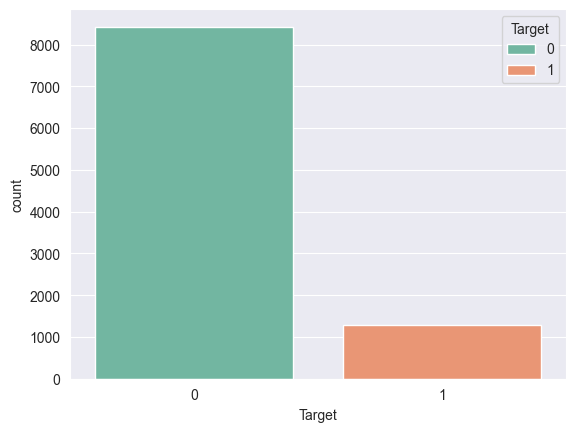

In [36]:
sns.countplot(x='Target', data=final_df, hue='Target', palette='Set2')